In [1]:
import gd
import comp
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape
y = 2*y-3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

L = np.max(np.linalg.eigvals(X.T @ X )).real/n
lambda_value = L/100
L


10.34485693561772

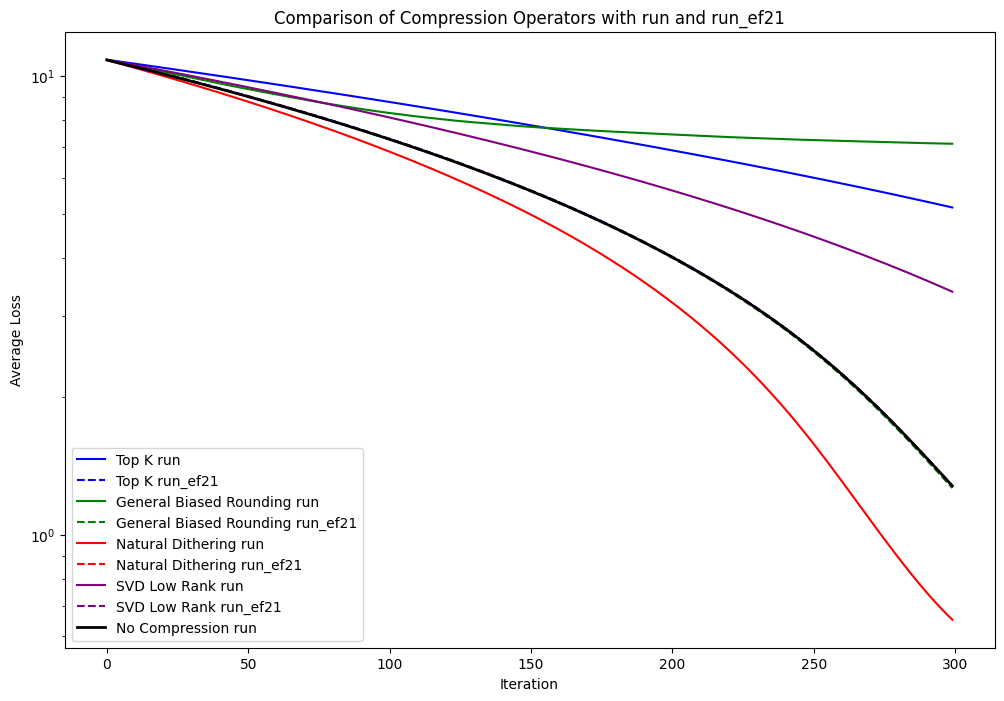

In [4]:

def loss(w, X, y, lambda_value):
    yXw = y * (X @ w)
    log_loss = np.mean(np.log(1 + np.exp(-yXw)))
    reg_loss = (lambda_value / 2) * np.dot(w, w)
    return log_loss + reg_loss

def loss_grad(w, X, y, lambda_value):
    yXw = y * (X @ w)
    log_grad = np.mean((-y * X.T)/(1+np.exp(+yXw)), axis=1)
    reg_grad = lambda_value * w
    return log_grad + reg_grad

f = gd.Func(
    func=loss,
    grad=loss_grad
)

def batch_generator(X, y, batch_size):
    n_samples = X.shape[0]
    for i in range(0, n_samples, batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])


workers = []
batch_size = 500
for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
    worker_func = gd.create_worker_func(f, X_batch, y_batch, lambda_value)
    workers.append(gd.Worker(worker_func))

dgd = gd.DistributedGD(workers, 1/11 * (1/(L+lambda_value)))

def plot_for_compression_operator(w0, num_iter, compress_op, name, color):
    for worker in workers:
        worker.compress_op = compress_op
    
    dgd.reset()
    dgd.run(num_iter, w0)
    run_loss_history = [loss(w, X_train, y_train, 0) for w in dgd.history]

    dgd.reset()
    dgd.run_ef21(num_iter, w0)
    run_ef21_loss_history = [loss(w, X_train, y_train, 0) for w in dgd.history if loss(w, X_train, y_train, 0) < loss(w0, X_train, y_train, 0)]


    plt.semilogy(run_loss_history, label=f'{name} run', color=color)
    plt.semilogy(run_ef21_loss_history, label=f'{name} run_ef21', linestyle='--', color=color)


plt.figure(figsize=(12, 8))

compression_operators = [
    (comp.top_k_op(10), 'Top K', 'blue'),
    (comp.general_biased_rounding_op(10, 1e-8, 100), 'General Biased Rounding', 'green'),
    (comp.natural_dithering_op(4), 'Natural Dithering', 'red'),
    (comp.svd_approximation_low_rank_compression_op(2), 'SVD Low Rank', 'purple')
]

w0 = np.ones(d) *(-1)
num_iter = 300 
for compress_op, name, color in compression_operators:
    plot_for_compression_operator(w0, num_iter, compress_op, name, color)

for worker in workers:
        worker.compress_op = lambda x: x 
    
dgd.reset()
dgd.run(num_iter, w0)
no_compression_loss_history = [loss(w, X_train, y_train, 0) for w in dgd.history]
plt.semilogy(no_compression_loss_history, label='No Compression run', color='black', linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.title('Comparison of Compression Operators with run and run_ef21')
plt.legend()
plt.show()

